# Building 3-D RAKI networks for MRSI reconstruction (ky undersampling)

@ author: Yunrui Zhang

@ create time: 09/20/2023

Reference: 

- Akçakaya M, Moeller S, Weingärtner S, Uğurbil K. Scan-specific robust artificial-neural-networks for k-space interpolation (RAKI) reconstruction: Database-free deep learning for fast imaging. Magn Reson Med. 2019;81(1):439-453. doi:10.1002/mrm.27420
- Open source code: https://github.com/zczam/rRAKI

In [1]:
import numpy as np 
import sigpy as sp
import pathlib
import h5py
import torch
import sys
sys.path.append('.')

from matplotlib import pyplot as plt
from cnn.rakiModels_3D import rakiReco_3D, irakiReco_3D
# from grappa.grappaReco_3D import grappa_3D
from utils.metrics import nmse, ssim, psnr, phase_mse
from utils.coilMapping import getMask

# TODO: edit rakiModels.py to include 3D RAKI model

import fastmri
from fastmri.data import transforms as T

device = 'cuda: from MacOS' if torch.cuda.is_available() else 'cpu: from MacOS'
print(device)

cpu: from MacOS


In [2]:

###################### Reconstruction Parameters ######################

#### Network Parameters ####
kernel_x_1 = 5
kernel_y_1 = 2
kernel_t_1 = 3

kernel_x_2 = 1
kernel_y_2 = 1
kernel_t_2 = 1

kernel_last_x = 3
kernel_last_y = 2
kernel_last_t = 3

layer1_channels = 32 
layer2_channels = 8

MaxIteration = 1000
LearningRate = 3e-3

######################################################################

In [3]:
DATADIR = pathlib.Path('../data/') # directory to k-space data and sampling mask
assert DATADIR.is_dir(), 'expected data directory non-existent'
file_name = 'neuro0' # file name of fully-sampled kspace 

ipat = np.load(DATADIR / (file_name + '_ipat.npy')) # undersampling mask 

print('Shape of undersampling mask: ', ipat.shape)



Shape of undersampling mask:  (320, 320)


In [43]:
# load .npy data (previously loaded from MRSI_dataloader.ipynb)

'''MRSIDIR = pathlib.Path('/Users/zhangyunrui/Documents/Grad_Application/summer_intern/lam_fan_uiuc/Research/data/MRSI_data4yunrui.mat')
assert MRSIDIR.is_file(), 'MRSI data not found in this directory!'
# # load data from .mat file from MRSIDIR, print its shape
# data_whole = h5py.File(SLICEDIR, 'r')
# data_whole = data_whole['ktD2All_odd']
# print('Shape of MRSI data (coil, t, kz, kx, ky): ', data_whole.shape)

# SLICEDIR = pathlib.Path('/Users/zhangyunrui/Documents/Grad_Application/summer_intern/lam_fan_uiuc/Research/data/preparedData4yunrui.npy')
# assert SLICEDIR.is_file(), 'MRSI data not found in this directory!'

# load data from .mat file from MRSIDIR, print its shape
data_whole = h5py.File(MRSIDIR, 'r')
data_whole = data_whole['ktD2All_even']
# data_whole = np.load(SLICEDIR).transpose(4,3,2,1,0)
data_whole = data_whole['real'] + 1j * \
    data_whole['imag']  # from structured to complex
print('Shape of MRSI data (coil, t, kz, kx, ky): ', data_whole.shape)'''

MRSIDIR = pathlib.Path('/Users/zhangyunrui/Documents/Grad_Application/summer_intern/lam_fan_uiuc/Research/data')
MRSINAME = pathlib.Path('MRSI_data4yunrui_odd.npy')
assert (MRSIDIR / MRSINAME).is_file(), 'MRSI data not found in this directory!'
data_whole = np.load(MRSIDIR / MRSINAME)
print('Shape of MRSI data (coil, t, kz, kx, ky): ', data_whole.shape)

# Do Inverse Fourier Transform along kz axis
data_spatial = np.fft.ifftshift(np.fft.ifft(data_whole, axis=2), axes=2)
data_spatial = data_spatial
print('Shape of MRSI data (ky, kx, z, t, coil) after spatial transform on kz: ',
      data_spatial.shape)
print('Datatype of MRSI data ', data_spatial.dtype)

z_idx = 10
data_slice = data_spatial[:, :, z_idx, :, :]
print('Shape of MRSI data slice (coil, t, kx, ky):', data_slice.shape)
print('data_slice.dtype: ', data_slice.dtype)


use_vcc = 0 # flag to use virtual-conjugate-coils for phase constraint reconstruction 
acs_flag = 1 # for inline calibration, the acs is put back into reconstructed k-space 

# read from .npy file
kspace_raw = data_slice.transpose(3,2,1,0)
print("The size of kspace slice (PE(y), RO(x), time, coil) is: ", kspace_raw.shape)

if use_vcc:
    kspace_raw = np.concatenate((kspace_raw, np.conjugate(np.flip(np.flip(kspace_raw,axis=1),axis=2))),axis=0)

# 11/7: commented this part
# check k-space scaling such that minimum signal has order of magnitude 0     
# scaling_fast = np.floor(np.log10(np.min(np.abs(kspace_raw[np.where(kspace_raw!=0)]))))
# kspace_raw *= 10**(-1*int(scaling_fast))

time_point = 0
y_size, x_size, nT, nC = np.shape(kspace_raw)
kspace_full = kspace_raw
kspace_full = np.transpose(kspace_full, (3,0,1,2))
print("The size of kspace slice (coil,PE(y), RO(x), time) is: ", np.shape(kspace_full))


Shape of MRSI data (coil, t, kz, kx, ky):  (16, 150, 20, 74, 74)
Shape of MRSI data (ky, kx, z, t, coil) after spatial transform on kz:  (16, 150, 20, 74, 74)
Datatype of MRSI data  complex128
Shape of MRSI data slice (coil, t, kx, ky): (16, 150, 74, 74)
data_slice.dtype:  complex128
The size of kspace slice (PE(y), RO(x), time, coil) is:  (74, 74, 150, 16)
The size of kspace slice (coil,PE(y), RO(x), time) is:  (16, 74, 74, 150)


In [44]:
# print the average and min, max real value of k-space data
print("Average real value of k-space data: ", np.mean(np.real(kspace_full)))
print("Average imag value of k-space data: ", np.mean(np.imag(kspace_full)))
print("Average abs value of k-space data: ", np.mean(np.abs(kspace_full)))
print("Min real value of k-space data: ", np.min(np.real(kspace_full)))
print("Min imag value of k-space data: ", np.min(np.imag(kspace_full)))
print("Min abs value of k-space data: ", np.min(np.abs(kspace_full)))
print("Max real value of k-space data: ", np.max(np.real(kspace_full)))
print("Max imag value of k-space data: ", np.max(np.imag(kspace_full)))
print("Max abs value of k-space data: ", np.max(np.abs(kspace_full)))

# 10/17: Add Gaussian noise to k-space data
noise_level = 0  # (10**4)*8
noise = np.random.normal(0, noise_level, kspace_full.shape) + 1j*np.random.normal(0, noise_level, kspace_full.shape)
kspace_full_0 = kspace_full
kspace_full = kspace_full + noise
print("Gaussian noise added to k-space data with noise level: ", noise_level)

Average real value of k-space data:  3.21292654846261e-09
Average imag value of k-space data:  -5.697340614930443e-09
Average abs value of k-space data:  1.4895839776692485e-06
Min real value of k-space data:  -0.00040658817242816934
Min imag value of k-space data:  -0.00041121066292892504
Min abs value of k-space data:  1.0731425197168385e-10
Max real value of k-space data:  0.0003413213359706405
Max imag value of k-space data:  0.0004913735098478828
Max abs value of k-space data:  0.0005082791240701132
Gaussian noise added to k-space data with noise level:  0


In [45]:
# Create undersampling mask
R = 2    # acceleration rate
ACS_width = 18  # ACS width
ipat = np.zeros([y_size, x_size])
ipat[::R, :] = 1
ipat[(y_size - ACS_width) // 2:(y_size + ACS_width) // 2, :] = 1
ipat = np.tile(ipat, (nC, nT, 1, 1))
ipat = np.transpose(ipat, (0,2,3,1))
print('The size of undersampling mask (coil,PE(y), RO(x), time) is: ', ipat.shape)

kspace_under = kspace_full * ipat
print("The size of under sampled k-space (coil,PE(y), RO(x), time) is: ", kspace_under.shape)

The size of undersampling mask (coil,PE(y), RO(x), time) is:  (16, 74, 74, 150)
The size of under sampled k-space (coil,PE(y), RO(x), time) is:  (16, 74, 74, 150)


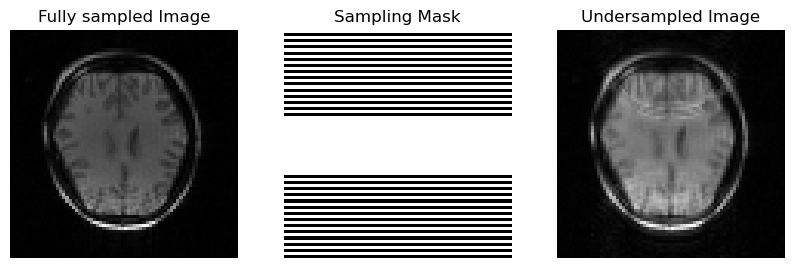

In [46]:
# Visualization

img_fast = sp.rss(sp.ifft(kspace_full[:,:,:,0], axes=[1,2]),0)
slice_image_rss = sp.rss(sp.ifft(kspace_full[:,:,:,0], axes=[1,2]),0)
under_image_rss = sp.rss(sp.ifft(kspace_under[:,:,:,0], axes=[1,2]),0)

fig, axs = plt.subplots(1,3, figsize=[10,10])
axs[0].imshow(slice_image_rss,cmap='gray')
axs[1].imshow(ipat[0,:,:,0],cmap='gray')
axs[2].imshow(under_image_rss,cmap='gray')

axs[0].set_title('Fully sampled Image')
axs[1].set_title('Sampling Mask')
axs[2].set_title('Undersampled Image')

for jj in range(3):
    axs[jj].axis('off')

In [47]:
acq = np.where(ipat[0][:,0,:]==1)[0] # get index of first non-zero sample
(nC, nP, nR, nT) = kspace_full.shape

acq_conti = np.where(acq[1:]-acq[:-1]==1)[0] 

acs_start = acq[acq_conti[0]]
acs_end = acq[acq_conti[-1]]+1
acs = kspace_full[:,acs_start:acs_end+1,:]
(_,nP_acs, nR_acs, nT_acs) = acs.shape 

R_eff = ((((nP-nP_acs)/R)+nP_acs)/nP)**-1
print('Acceleration Factor: ', str(R), '\n', 'Number ACS Lines: ', str(nP_acs), '/', str(nP), '\n', 'Effective Acceleration Factor: ', '{:.2f}'.format(R_eff))

Acceleration Factor:  2 
 Number ACS Lines:  19 / 74 
 Effective Acceleration Factor:  1.59


In [29]:
layer_design_raki = {'num_hid_layer': 2, # number of hidden layers, in this case, its 2
                    'input_unit': nC,    # number channels in input layer, nC is coil number 
                        1:[256,(2,5,2)],   # the first hidden layer has 256 channels, and a kernel size of (2,5,3) in PE- and RO-direction
                        2:[128,(1,1,1)],   # the second hidden layer has 128 channels, and a kernel size of (1,1,1) in PE- and RO-direction
                    'output_unit':[(R-1)*nC,(1,5,1)] # the output layer has (R-1)*nC channels, and a kernel size of (1,5,3) in PE- and RO-direction
                    }

raki_reco = rakiReco_3D(np.copy(kspace_under), acs, R, layer_design_raki) # get standard RAKI reconstruction

if acs_flag: # put ACS back into reconstructed k-space
    raki_reco[:, acs_start:acs_end+1, :, :] = acs

Starting Standard RAKI...
The shape of pseudo kernels is (Nk_p, Nk_r, Nk_t):  2 9 2
The shape of acs is (num_coils, num_p_acs, num_r_acs, num_t_acs):  (16, 19, 74, 150)
The repetitions are:  rep_r_acs:  66 rep_t_acs:  149 rep_p_acs:  16
Kernel_extension_p is:  4
The shape of trg_data is (rep_p_acs, rep_r_acs, rep_t_acs, dim_trg_vec):  (16, 66, 149, 32)
The shape of src_data is (rep_p_acs, num_coils, kernel_extension_p, num_r_acs, num_t_acs):  (16, 16, 4, 74, 150)


100%|██████████| 500/500 [36:23<00:00,  4.37s/it]


Finished Standard RAKI...


In [30]:
import datetime
import os

# save the train results in a .npy file
train_ver = 'v11'
SAVETRAINDIR = pathlib.Path('/Volumes/YRZHANG/summer_intern/data4yunrui/train_result_temp/RAKI_MRSI_ky_undersampled') / ('train_' + train_ver)
SAVEFILE_RECON = 'raki_mrsi_reco_para_' + train_ver + '_R=' + str(R) + '.npy'
# save the raki_reco result in a .npy file
os.makedirs(SAVETRAINDIR, exist_ok=True)
np.save(SAVETRAINDIR / SAVEFILE_RECON, raki_reco)

# save the parameters in a .txt file
SAVEFILE = 'raki_mrsi_reco_para_ky_undersampled' +  '.txt'
with open(SAVETRAINDIR / SAVEFILE, 'a') as f:
    print('Training version: ', train_ver, file=f)
    print('Training time: ', datetime.datetime.now(), file=f)
    print('undersampling factor: ', R, file=f)
    print('num_hid_layer: ', layer_design_raki['num_hid_layer'], file=f)
    print('coil number:', layer_design_raki['input_unit'], file=f)
    print('1st layer kernel size: ', layer_design_raki[1], file=f)
    print('2nd layer kernel size: ', layer_design_raki[2], file=f)
    # print('layer_unit: number of channels', layer_design_raki['input_unit'][0], file=f)
    # print('layer_unit: 1st layer', layer_design_raki['input_unit'][1], file=f)
    print('output layer kernel size: ', layer_design_raki['output_unit'], file=f)
    print(' ', file=f)

In [34]:
from importlib import reload
import grappa.grappaReco_3D
reload(grappa.grappaReco_3D)
from grappa.grappaReco_3D import grappa_3D

grappa_reco = grappa_3D(np.copy(kspace_under), acs, R, {'phase':3, 'read':3, 'time':3}, 0.0001)

if acs_flag:
    grappa_reco[:, acs_start:acs_end+1,:] = acs

debug
Loading Source - & Target Matrix ... 


KeyboardInterrupt: 

In [51]:
# 10/30: Load grappa recon result from .npy file
train_ver = '74_v4_whole'
SAVETRAINDIR = pathlib.Path(
    '/Users/zhangyunrui/Documents/Grad_Application/summer_intern/lam_fan_uiuc/Research/data/result/train_result_whole/RAKI_MRSI_3D_whole_train_' + train_ver)
SAVEFILE_RECON_GRAPPA = 'grappa_mrsi_reco_ky_74_odd_R=2.npy' 
 # +  train_ver + '_R=' + str(R) + '.npy'
grappa_reco = np.load(SAVETRAINDIR / SAVEFILE_RECON_GRAPPA)
grappa_reco = grappa_reco[:, :, z_idx, :, :]

In [39]:
msk = getMask(kspace_full)

KeyboardInterrupt: 

In [40]:
SAVETRAINDIR = pathlib.Path('/Users/zhangyunrui/Documents/Grad_Application/summer_intern/lam_fan_uiuc/Research/data/result/RAKI_MRSI_ky_t_CAIPI_3') / ('train_' + 'v2')
SAVEFILE_MSK = 'raki_mrsi_reco_msk_' + 'v2_74' + '.npy'
msk = np.load(SAVETRAINDIR / SAVEFILE_MSK)

In [48]:
# 10/29: Test for whole z-direction
train_ver = '74_v4_whole'
SAVETRAINDIR = pathlib.Path(
    '/Users/zhangyunrui/Documents/Grad_Application/summer_intern/lam_fan_uiuc/Research/data/result/train_result_whole/RAKI_MRSI_3D_whole_train_' + train_ver)
SAVEFILE_RECON = 'raki_mrsi_reco_ky_74_odd_R=2.npy' 
 # + train_ver + '_R=' + str(R) + '.npy'
raki_reco = np.load(SAVETRAINDIR / SAVEFILE_RECON)
raki_reco = raki_reco[:, :, z_idx, :, :].transpose(3, 0, 1, 2)

In [49]:
print("Shape of kspace: ", kspace_full.shape)
print("Shape of grappa: ", grappa_reco.shape)
print("Shape of raki: ", raki_reco.shape)
raki_reco = raki_reco.transpose(1,2,3,0)

Shape of kspace:  (16, 74, 74, 150)
Shape of grappa:  (16, 74, 74, 150)
Shape of raki:  (150, 16, 74, 74)


    GRAPPA RAKI UNDERSAMPLED
NMSE 0.5   0.2   183.6
PSNR 54.9   58.9   29.5
SSIM 99.9   99.9   92.5


"# save the results to a txt file, don't rewrite\nSAVEMSE = 'coil_combination_MSE_' + train_ver + '.txt'\nwith open(SAVETRAINDIR / SAVEMSE, 'a') as f:\n    f.write('result/RAKI_MRSI_3D_recon/3D_t={}_R={}\n'.format(time_point_ind, R))\n    f.write('GRAPPA ' + 'RAKI '+ 'UNDERSAMPLED \n')\n    f.write('NMSE: {} {} {}\n'.format(str(np.around(1e4*nmse_grappa,1)), str(np.around(1e4*nmse_raki,1)), str(np.around(1e4*nmse_under,1))))\n    f.write('PSNR: {} {} {}\n'.format(str(np.around(psnr_grappa,1)),str(np.around(psnr_raki,1)), str(np.around(psnr_under,1))))\n    f.write('SSIM: {} {} {}\n'.format(str(np.around(1e2*ssim_grappa,1)), str(np.around(1e2*ssim_raki,1)), str(np.around(1e2*ssim_under,1))))\n    f.write(' \n')\n"

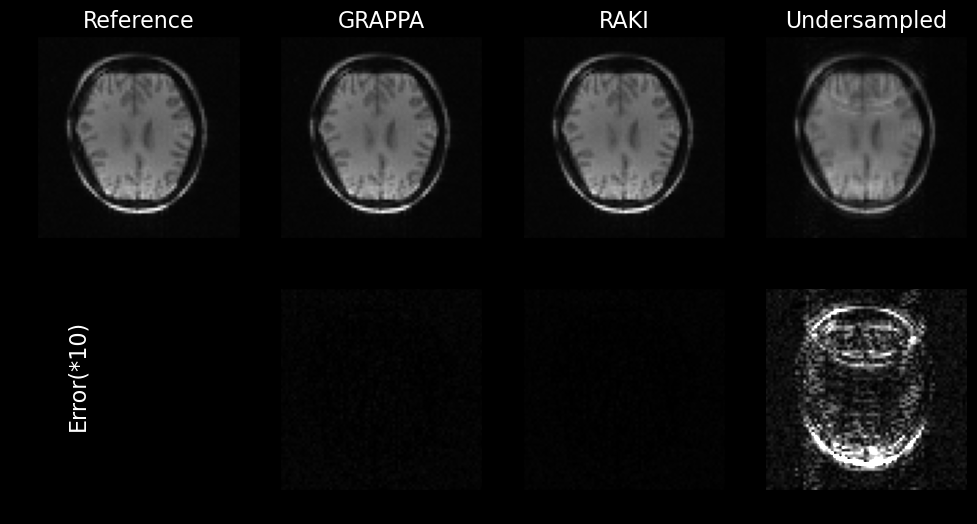

In [52]:
time_point_ind = 2

reference = sp.ifft(kspace_full[:,:,:,time_point_ind], axes=[1,2])
reference = sp.rss(reference, 0)
# reference = reference * msk[:,:,time_point_ind]
reference = reference 
diff_reference = np.abs(reference - reference)

raki_recoFFT = sp.ifft(raki_reco[:,:,:,time_point_ind], axes=[1, 2])
raki_recoFFT = sp.rss(raki_recoFFT, 0)  
raki_recoFFT = raki_recoFFT 
diff_raki = np.abs(reference - raki_recoFFT)
nmse_raki = nmse(reference, raki_recoFFT)
psnr_raki = psnr(reference, raki_recoFFT)
ssim_raki = ssim(reference, raki_recoFFT)

grappa_recoFFT = sp.ifft(grappa_reco[:,:,:,time_point_ind], axes=[1, 2])
grappa_recoFFT = sp.rss(grappa_recoFFT, 0)  
grappa_recoFFT = grappa_recoFFT
diff_grappa = np.abs(reference - grappa_recoFFT)
nmse_grappa = nmse(reference, grappa_recoFFT)
psnr_grappa = psnr(reference, grappa_recoFFT)
ssim_grappa = ssim(reference, grappa_recoFFT)

under_recoFFT = sp.ifft(kspace_under[:,:,:,time_point_ind], axes=[1, 2])
under_recoFFT = sp.rss(under_recoFFT, 0)  
under_recoFFT = under_recoFFT 
diff_under = np.abs(reference - under_recoFFT)
nmse_under = nmse(reference, under_recoFFT)
psnr_under = psnr(reference, under_recoFFT)
ssim_under = ssim(reference, under_recoFFT)

max_rss = np.max(np.abs(reference))
alpha = 1.0
diffScaling = 1e1

font = {'fontsize':16, 'color': 'white'}
fig, axs = plt.subplots(2,4,figsize=[12,6], facecolor='k')

axs[0,0].imshow(np.abs(reference), cmap='gray', vmin=0, vmax=max_rss*alpha)
axs[0,1].imshow(np.abs(grappa_recoFFT), cmap='gray', vmin=0, vmax=max_rss*alpha)
axs[0,2].imshow(np.abs(raki_recoFFT), cmap='gray', vmin=0, vmax=max_rss*alpha)
axs[0,3].imshow(np.abs(under_recoFFT), cmap='gray', vmin=0, vmax=max_rss*alpha)

axs[1,0].imshow(np.abs(diff_reference*diffScaling), cmap='gray', vmin=0, vmax=max_rss*alpha)
axs[1,1].imshow(np.abs(diff_grappa*diffScaling), cmap='gray', vmin=0, vmax=max_rss*alpha)
axs[1,2].imshow(np.abs(diff_raki*diffScaling), cmap='gray', vmin=0, vmax=max_rss*alpha)
axs[1,3].imshow(np.abs(diff_under*diffScaling), cmap='gray', vmin=0, vmax=max_rss*alpha)

axs[0,0].set_title('Reference', fontdict=font)
axs[0,1].set_title('GRAPPA', fontdict=font)
axs[0,2].set_title('RAKI', fontdict=font)
axs[0,3].set_title('Undersampled', fontdict=font)
axs[1,0].text(10,50, 'Error(*10)', rotation=90, fontdict=font)


print(3*' ', 'GRAPPA', 'RAKI', 'UNDERSAMPLED')

print('NMSE', str(np.around(1e4*nmse_grappa,1)),' ',str(np.around(1e4*nmse_raki,1)), ' ',str(np.around(1e4*nmse_under,1)))
print('PSNR', str(np.around(psnr_grappa,1)),' ',str(np.around(psnr_raki,1)), ' ',str(np.around(psnr_under,1)))
print('SSIM', str(np.around(1e2*ssim_grappa,1)),' ',str(np.around(1e2*ssim_raki,1)), ' ',str(np.around(1e2*ssim_under,1)))

# save the figure
SAVEFIG = 'coil_combination_' + train_ver + '_R={}_t={}.png'.format(R, time_point_ind)
fig.savefig(SAVETRAINDIR / SAVEFIG, dpi=300, bbox_inches='tight', pad_inches=0)

'''# save the results to a txt file, don't rewrite
SAVEMSE = 'coil_combination_MSE_' + train_ver + '.txt'
with open(SAVETRAINDIR / SAVEMSE, 'a') as f:
    f.write('result/RAKI_MRSI_3D_recon/3D_t={}_R={}\n'.format(time_point_ind, R))
    f.write('GRAPPA ' + 'RAKI '+ 'UNDERSAMPLED \n')
    f.write('NMSE: {} {} {}\n'.format(str(np.around(1e4*nmse_grappa,1)), str(np.around(1e4*nmse_raki,1)), str(np.around(1e4*nmse_under,1))))
    f.write('PSNR: {} {} {}\n'.format(str(np.around(psnr_grappa,1)),str(np.around(psnr_raki,1)), str(np.around(psnr_under,1))))
    f.write('SSIM: {} {} {}\n'.format(str(np.around(1e2*ssim_grappa,1)), str(np.around(1e2*ssim_raki,1)), str(np.around(1e2*ssim_under,1))))
    f.write(' \n')
'''

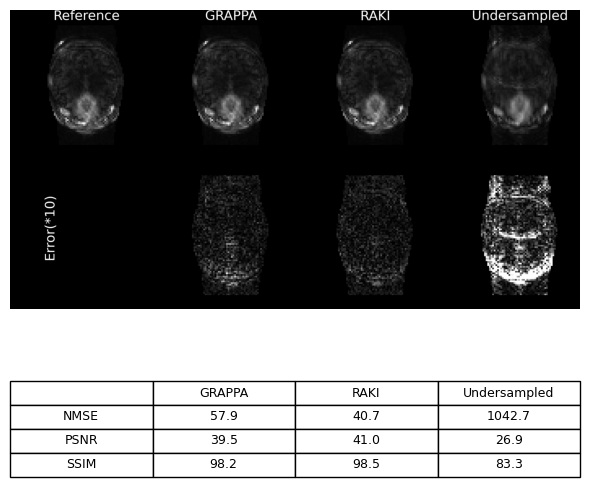

In [48]:
# Draw a table (together with image) to compare the results

import matplotlib.pyplot as plt
from matplotlib.table import table

criterion_data = [
    [" ", "GRAPPA", "RAKI", "Undersampled"],
    ["NMSE", np.around(1e4*nmse_grappa,1), np.around(1e4*nmse_raki,1), np.around(1e4*nmse_under,1)],
    ["PSNR", np.around(psnr_grappa,1), np.around(psnr_raki,1), np.around(psnr_under,1)],
    ["SSIM", np.around(1e2*ssim_grappa,1), np.around(1e2*ssim_raki,1), np.around(1e2*ssim_under,1)]
]

fig, axs = plt.subplots(2, 1, figsize=(6, 6), gridspec_kw={'height_ratios': [4, 1]})


# Create the table in the first subplot
tab = table(axs[1], cellText=criterion_data, loc='center', cellLoc='center')
tab.auto_set_font_size(True)
tab.scale(1, 1)
axs[1].axis('off')

# Load and display your images in the second and third subplots
# Load your first image
image_recon = plt.imread(SAVETRAINDIR / SAVEFIG)

axs[0].imshow(image_recon)
axs[0].axis('off')


# Adjust spacing between subplots
plt.tight_layout()

# Show the figure
plt.show()


In [20]:
import tqdm

# save multiple time point results: in range nT, every 1 time point(s)
for time_point_ind in tqdm.trange(0, nT, 1):
    reference = sp.ifft(kspace_full[:,:,:,time_point_ind], axes=[1,2])
    reference = sp.rss(reference, 0)
    reference = reference * msk[:,:,time_point_ind]
    diff_reference = np.abs(reference - reference)

    raki_recoFFT = sp.ifft(raki_reco[:,:,:,time_point_ind], axes=[1, 2])
    raki_recoFFT = sp.rss(raki_recoFFT, 0)  
    raki_recoFFT = raki_recoFFT * msk[:,:,time_point_ind]
    diff_raki = np.abs(reference - raki_recoFFT)
    nmse_raki = nmse(reference, raki_recoFFT)
    psnr_raki = psnr(reference, raki_recoFFT)
    ssim_raki = ssim(reference, raki_recoFFT)

    grappa_recoFFT = sp.ifft(grappa_reco[:,:,:,time_point_ind], axes=[1, 2])
    grappa_recoFFT = sp.rss(grappa_recoFFT, 0)  
    grappa_recoFFT = grappa_recoFFT * msk[:,:,time_point_ind]
    diff_grappa = np.abs(reference - grappa_recoFFT)
    nmse_grappa = nmse(reference, grappa_recoFFT)
    psnr_grappa = psnr(reference, grappa_recoFFT)
    ssim_grappa = ssim(reference, grappa_recoFFT)

    under_recoFFT = sp.ifft(kspace_under[:,:,:,time_point_ind], axes=[1, 2])
    under_recoFFT = sp.rss(under_recoFFT, 0)  
    under_recoFFT = under_recoFFT * msk[:,:,time_point_ind]
    diff_under = np.abs(reference - under_recoFFT)
    nmse_under = nmse(reference, under_recoFFT)
    psnr_under = psnr(reference, under_recoFFT)
    ssim_under = ssim(reference, under_recoFFT)

    max_rss = np.max(np.abs(reference))
    alpha = 1.0
    diffScaling = 1e1

    font = {'fontsize':24, 'color': 'white'}
    fig, axs = plt.subplots(2,4,figsize=[12,6], facecolor='k')

    axs[0,0].imshow(np.abs(reference), cmap='gray', vmin=0, vmax=max_rss*alpha)
    axs[0,1].imshow(np.abs(grappa_recoFFT), cmap='gray', vmin=0, vmax=max_rss*alpha)
    axs[0,2].imshow(np.abs(raki_recoFFT), cmap='gray', vmin=0, vmax=max_rss*alpha)
    axs[0,3].imshow(np.abs(under_recoFFT), cmap='gray', vmin=0, vmax=max_rss*alpha)

    axs[1,0].imshow(np.abs(diff_reference*diffScaling), cmap='gray', vmin=0, vmax=max_rss*alpha)
    axs[1,1].imshow(np.abs(diff_grappa*diffScaling), cmap='gray', vmin=0, vmax=max_rss*alpha)
    axs[1,2].imshow(np.abs(diff_raki*diffScaling), cmap='gray', vmin=0, vmax=max_rss*alpha)
    axs[1,3].imshow(np.abs(diff_under*diffScaling), cmap='gray', vmin=0, vmax=max_rss*alpha)

    axs[0,0].set_title('Reference', fontdict=font)
    axs[0,1].set_title('GRAPPA', fontdict=font)
    axs[0,2].set_title('RAKI', fontdict=font)
    axs[0,3].set_title('Undersampled', fontdict=font)
    axs[1,0].text(10,50, 'Error (x10)', rotation=90, fontdict=font)
    
    # save the figure
    os.makedirs(SAVETRAINDIR / 'image', exist_ok=True)
    SAVEFIG = 'image/coil_combination_' + train_ver + '_R=' + str(R) + '_t={}.png'.format(time_point_ind)
    fig.savefig(SAVETRAINDIR / SAVEFIG, dpi=300, bbox_inches='tight', pad_inches=0)

    # save the results to a txt file, don't rewrite
    SAVEMSE = 'coil_combination_MSE_' + train_ver + '_R=' + str(R) + '.txt'
    with open(SAVETRAINDIR / SAVEMSE, 'a') as f:
        f.write('result/RAKI_MRSI_3D_recon/3D_t={}_R={}\n'.format(time_point_ind, R))
        f.write('GRAPPA ' + 'RAKI '+ 'UNDERSAMPLED \n')
        f.write('NMSE: {} {} {}\n'.format(str(np.around(1e4*nmse_grappa,1)), str(np.around(1e4*nmse_raki,1)), str(np.around(1e4*nmse_under,1))))
        f.write('PSNR: {} {} {}\n'.format(str(np.around(psnr_grappa,1)),str(np.around(psnr_raki,1)), str(np.around(psnr_under,1))))
        f.write('SSIM: {} {} {}\n'.format(str(np.around(1e2*ssim_grappa,1)), str(np.around(1e2*ssim_raki,1)), str(np.around(1e2*ssim_under,1))))
        f.write(' \n')
    
    # save the image to the folder
    # plt.savefig('../result/RAKI_MRSI_3D_recon/3D_t={}_R={}.png'.format(time_point_ind, R), facecolor='k', bbox_inches='tight', pad_inches=0)
    plt.close()


  0%|          | 0/150 [00:00<?, ?it/s]

100%|██████████| 150/150 [03:06<00:00,  1.24s/it]
